In [ ]:
# !pip install pandas

In [ ]:
# pip install matplotlib

In [ ]:
# pip install seaborn

In [32]:
import os
import glob
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def merge_json_to_csv(json_folder_path, output_csv_path):
    """
    Merges JSON files into a single CSV file.

    Parameters:
    - json_folder_path: The folder path where the JSON files are stored.
    - output_csv_path: The path to save the merged CSV file.
    """
    json_pattern = os.path.join(json_folder_path, 'persian_*.jsonl')  # Adjust the pattern

    # Find all JSON files matching the pattern
    json_files = glob.glob(json_pattern)

    # Initialize an empty list to store the data
    data = []

    # Loop through the list of files
    for file in json_files:
        with open(file, 'r', encoding='utf-8') as f:
            for line in f:  # Each file contains multiple JSON objects, one per line
                json_obj = json.loads(line)  # Convert JSON string to Python dictionary
                data.append(json_obj)  # Add the dictionary to our list

    # Convert the list of dictionaries to a pandas DataFrame
    df = pd.DataFrame(data)

    # Save the DataFrame to a CSV file
    df.to_csv(output_csv_path, index=False, encoding='utf-8')

    print(f'Merged CSV file has been saved to: {output_csv_path}')


In [3]:
# Define the path to JSON files and the output CSV file path
json_folder_path = r'C:/Users/amirm/Desktop/MONASH/Thesis/Working/Prepare/Original_Datasets/XLSum/persian_XLSum_v2.0'

output_csv_path = os.path.join(json_folder_path, '1_merged_data.csv')

# Call the function
merge_json_to_csv(json_folder_path, output_csv_path)

Merged CSV file has been saved to: C:/Users/amirm/Desktop/MONASH/Thesis/Working/Datasets/XLSum/persian_XLSum_v2.0\1_merged_data.csv


In [33]:
# The actual path merged CSV file
csv_path = 'C:/Users/amirm/Desktop/MONASH/Thesis/Working/Prepare/Original_Datasets/XLSum/persian_XLSum_v2.0/1_merged_data.csv'

df = pd.read_csv(csv_path, encoding='utf-8')


In [34]:
total_rows = len(df)
print(f'Total rows: {total_rows}')


Total rows: 59063


In [35]:
unique_titles = df['title'].nunique()
print(f'Unique titles: {unique_titles}')


Unique titles: 58581


count    59063.000000
mean       611.517617
std        601.481725
min          1.000000
25%        299.000000
50%        447.000000
75%        719.000000
max      25033.000000
Name: word_count, dtype: float64


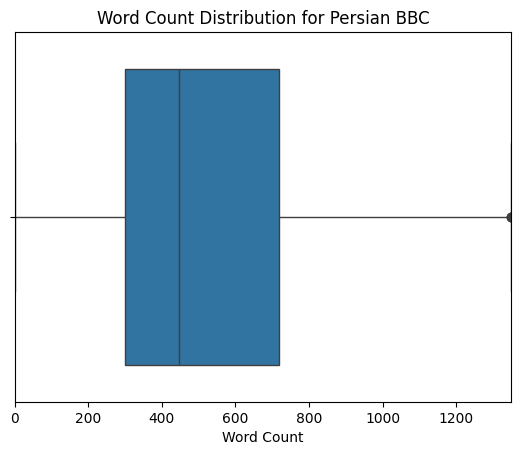

In [36]:
# Calculate the word count for each 'text'
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# Descriptive statistics for word counts
stats = df['word_count'].describe()
print(stats)

# Plotting a boxplot for the word counts
sns.boxplot(x=df['word_count'])
plt.title('Word Count Distribution for Persian BBC')
plt.xlabel('Word Count')
# limit the x-axis to remove extreme outliers for better visualization
plt.xlim(0, stats["75%"] + 1.5 * (stats["75%"] - stats["25%"]))  # This limits the view to the typical range of data
plt.show()

In [26]:
def select_random_unique_titles_save_csv(df, num_titles, min_word_count, max_word_count, random_seed, output_csv_path):
    """
    Selects a specified number of random rows with unique titles from a DataFrame, where each selected row's 'text' has
    more than 'min_word_count' words and less than or equal to 'max_word_count' words, and saves the result to a CSV file.

    Parameters:
    - df: pandas DataFrame containing the data.
    - num_titles: The number of unique titles to select.
    - min_word_count: Minimum number of words required in the 'text' column to consider a row for selection.
    - max_word_count: Maximum number of words allowed in the 'text' column to consider a row for selection.
    - random_seed: The seed for the random number generator to ensure reproducibility. 
    - output_csv_path: The path to save the output CSV file. 

    Returns:
    - A pandas DataFrame containing the selected rows, also saved as a CSV file.
    """
    # Set a seed for reproducibility
    np.random.seed(random_seed)

    # Filter the DataFrame to only include rows with 'text' longer than 'min_word_count' and less than or equal to 'max_word_count' words
    # Convert all values in 'text' column to string to avoid AttributeError
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)
    # Replace the newline characters with a space
    df['text'] = df['text'].str.replace('\n', ' ')
    df_filtered = df[(df['word_count'] > min_word_count) & (df['word_count'] <= max_word_count)]

    # Shuffle the filtered dataset
    df_shuffled = df_filtered.sample(frac=1).reset_index(drop=True)

    # Select unique titles randomly from the filtered set
    unique_titles = df_shuffled['title'].unique()[:num_titles]

    # Initialize an empty DataFrame to store selected rows
    selected_rows = pd.DataFrame()

    for title in unique_titles:
        # For each title, randomly select a row from the filtered set
        rows = df_shuffled[df_shuffled['title'] == title].sample(n=1)
        selected_rows = pd.concat([selected_rows, rows], ignore_index=True)

    # Drop the 'word_count' column added for filtering
    selected_rows = selected_rows.drop(columns=['word_count'])

    # Save the selected rows to a new CSV file
    selected_rows.to_csv(output_csv_path, index=False, encoding='utf-8')
    
    print(f'Selected rows saved to {output_csv_path}')

    return selected_rows


In [ ]:
# Specify the output CSV file name/path
output_csv_name = 'C:/Users/amirm/Desktop/MONASH/Thesis/Working/Prepare/Original_Datasets/XLSum/persian_XLSum_v2.0/2_selected_unique_titles.csv'

# Call the function with the DataFrame, desired parameters, and output file name
selected_rows = select_random_unique_titles_save_csv(df, num_titles=2000,
                                                     min_word_count=400, 
                                                     max_word_count=700, 
                                                     random_seed=42, 
                                                     output_csv_path=output_csv_name)


In [37]:
def select_random_word_count_texts_save_csv(df, num_titles, random_seed, output_csv_path):
    """
    Selects a specified number of random rows with unique titles from a DataFrame, ensuring that each selected row's 'text'
    has more than 100 words. For each selected row's 'text', a random number of words between 50 and 100 is selected from 
    the beginning of the text. The modified rows are saved to a CSV file.

    Parameters:
    - df: pandas DataFrame containing the data.
    - num_titles: The number of unique titles to select.
    - random_seed: The seed for the random number generator to ensure reproducibility.
    - output_csv_path: The path to save the output CSV file. 

    Returns:
    - A pandas DataFrame containing the selected rows, also saved as a CSV file.
    """
    # Set a seed for reproducibility
    np.random.seed(random_seed)
    
    # Ensure the 'text' column is a string to avoid errors and replace newline characters with a space
    df['text'] = df['text'].astype(str).str.replace('\n', ' ')

    # Filter out rows where 'text' has 100 words or fewer
    df = df[df['text'].apply(lambda x: len(x.split()) > 100)]

    # Shuffle the dataset
    df_shuffled = df.sample(frac=1, random_state=random_seed).reset_index(drop=True)

    # Select unique titles randomly from the shuffled set
    unique_titles = df_shuffled['title'].unique()[:num_titles]

    # Initialize an empty DataFrame to store selected rows
    selected_rows = pd.DataFrame()

    for title in unique_titles:
        # For each title, randomly select a row that meets the text length requirement
        row = df_shuffled[df_shuffled['title'] == title].sample(n=1, random_state=random_seed)
        text = row['text'].iloc[0]
        words = text.split()
        
        # Choose a random number of words between 50 and 100 to select from the text
        num_words = np.random.randint(50, 101)
        selected_text = ' '.join(words[:num_words])
        
        # Update the text in the row
        row['text'] = selected_text
        selected_rows = pd.concat([selected_rows, row], ignore_index=True)

    # Save the selected rows to a new CSV file
    selected_rows.to_csv(output_csv_path, index=False, encoding='utf-8')
    
    print(f'Selected rows saved to {output_csv_path}')

    return selected_rows


In [38]:
# Specify the output CSV file name/path
output_csv_name = 'C:/Users/amirm/Desktop/MONASH/Thesis/Working/Prepare/Original_Datasets/XLSum/persian_XLSum_v2.0/2_selected_unique_titles.csv'

# Call the function with the DataFrame, desired parameters, and output file name
selected_rows = select_random_word_count_texts_save_csv(df, num_titles=2000, random_seed=42, output_csv_path=output_csv_name)

Selected rows saved to C:/Users/amirm/Desktop/MONASH/Thesis/Working/Prepare/Original_Datasets/XLSum/persian_XLSum_v2.0/2_selected_unique_titles.csv


In [39]:
selected_rows

,id,url,title,summary,text,word_count
0,140413_l45_ukraine_anti_terrorist,https://www.bbc.com/persian/world/2014/04/1404...,آمادگی نیروهای مسلح اوکراین برای عملیات تمام ع...,اولکساندر تورچینوف، رئیس جمهور موقت اوکراین، ا...,هواداران روسیه در برخی شهرهای شرق اوکراین کنتر...,265
1,world-38609942,https://www.bbc.com/persian/world-38609942,فیلمبردار مجار که به مهاجران لگد زده بود محکوم شد,فیلمبردار مجار که در ویدیو ی ی در حال لگد زدن ...,پترا لازلو به مردی که کودکی در بغل دارد، پشت پ...,234
2,blog-viewpoints-54358693,https://www.bbc.com/persian/blog-viewpoints-54...,مناظره‌های انتخاباتی پرده از واقعیت‌ها برمی‌دا...,مناظره‌های انتخاباتی تلویزیونی میان نامزدهای ر...,"همان طور که دبیران وب‌سایت ""تاریخ"" در مقالۀ ""م...",1533
3,magazine-56384251,https://www.bbc.com/persian/magazine-56384251,'کابوس پورن انتقامی همچنان با من است',"""فقط می‌خواستم دوستم داشته باشند. می‌خواستم با...",زارا مک درموت زارا مک‌درموت، ستاره بریتانیایی ...,1809
4,science-43620307,https://www.bbc.com/persian/science-43620307,چرا زنها بیشتر از مردها عمر می‌کنند؟,براساس تازه‌ترین داده‌های بنیاد سنجش و ارزیابی...,چرا زنها بیشتر از مردها عمر می‌کنند؟ این سه کش...,672
...,...,...,...,...,...,...
1995,afghanistan-39276444,https://www.bbc.com/persian/afghanistan-39276444,والی قندهار: حمله به مهمانخانه قندهار کار طالب...,همایون عزیزی والی قندهار که برای تداوی به فران...,والی قندهار که در حمله به مهمانخانه‌اش زخمی شد...,327
1996,130920_u07_syria_watchdog_chemical_weapon_data,https://www.bbc.com/persian/world/2013/09/1309...,بررسی سلاح‌های شیمیایی سوریه آغاز شد,سازمان دیدبان تسلیحات نظامی می‌گوید بررسی اطلا...,سوریه موافقت کرده است که تا پایان روز شنبه (۲۱...,335
1997,130924_u08_rouhani_netanyahu_negative,https://www.bbc.com/persian/iran/2013/09/13092...,واکنش منفی نخست‌‌وزیر اسرائیل به سخنان حسن روحانی,بنیامین نتانیاهو، نخست وزیر اسرائیل با انتقاد ...,بنیامین نتانیاهو می‌گوید برنامه ایران این است ...,346
1998,050424_la-pope-inauguration,https://www.bbc.com/persian/news/story/2005/04...,پاپ خواستار اتحاد مسيحيان شد,هزاران نفر برای شرکت در مراسم آغاز به کار پاپ ...,پاپ جديد در جريان اين مراسم اولين موعظه خود را...,325


In [40]:
def modify_and_save_df(df, output_csv_path, additional_columns_info=None):
    """
    Modifies the DataFrame by selecting specific columns, adding new ones, and saves to a CSV file.
    
    Parameters:
    - df: The DataFrame to be modified.
    - output_csv_path: The path (including filename) where the modified DataFrame should be saved as a CSV.
    - additional_columns_info: Dictionary with column names as keys and default values as values. Optional.
    
    Returns:
    - The modified DataFrame.
    """
    # Select only "title" and "text" columns if they exist in the DataFrame
    if {'title', 'text'}.issubset(df.columns):
        df_modified = df[['title', 'text']].copy()
    else:
        print("Required columns ('title', 'text') are missing in the DataFrame.")
        return None
    
    # Default columns and their values if not provided
    if additional_columns_info is None:
        additional_columns_info = {
            'write_by': 'Human',
            'language': 'Persian',
            'domain': 'BBC',
            'method': np.nan,  # use np.nan for null values
            'LLM_model': np.nan,
            'label': '1'  #  1 for Human labels
        }
    
    # Add the additional columns with their default values
    for column, value in additional_columns_info.items():
        df_modified[column] = value
    
    # Save the modified DataFrame to a new CSV file
    df_modified.to_csv(output_csv_path, index=False, encoding='utf-8')
    
    print(f'Modified DataFrame saved to: {output_csv_path}')
    
    return df_modified




In [41]:
output_csv_name = 'C:/Users/amirm/Desktop/MONASH/Thesis/Working/Prepare/Original_Datasets/XLSum/persian_XLSum_v2.0/3_modified_selected_rows_XLSum_fa.csv'
modified_df = modify_and_save_df(selected_rows, output_csv_name)

Modified DataFrame saved to: C:/Users/amirm/Desktop/MONASH/Thesis/Working/Prepare/Original_Datasets/XLSum/persian_XLSum_v2.0/3_modified_selected_rows_XLSum_fa.csv


In [42]:
def divide_and_save_csv(input_csv_path):
    """
    Reads a CSV file, divides the rows into chunks of 1000, and saves them into separate CSV files in the same directory.
    The filenames are based on unique values in the 'domain', 'language', and 'write_by' columns.

    Parameters:
    - input_csv_path: The path to the input CSV file.
    """
    # Read the CSV file
    df = pd.read_csv(input_csv_path)
    
    # Extract directory from the input CSV path
    directory = os.path.dirname(input_csv_path)
    
    # Extracting unique values for filename components
    domain = df['domain'].unique()[0]
    language = df['language'].unique()[0]
    write_by = df['write_by'].unique()[0]
    
    # Calculating the number of chunks
    num_chunks = len(df) // 1000
    if len(df) % 1000 > 0:
        num_chunks += 1
    
    # Divide the DataFrame into chunks and save them
    for i in range(num_chunks):
        start_index = i * 1000
        end_index = start_index + 1000
        chunk = df.iloc[start_index:end_index]
        
        # Naming and saving each chunk based on its order
        if i == 0:
            filename = f"{domain}_{language}_{write_by}_Topic.csv"
        else:
            filename = f"{domain}_{language}_{write_by}_Continue.csv"
        
        # Constructing full path for the output file
        output_file_path = os.path.join(directory, filename)
        
        chunk.to_csv(output_file_path, index=False)
        print(f"Chunk {i+1}/{num_chunks} saved to {output_file_path}")


In [43]:
# Specify the input CSV file name/path
input_csv_name = 'C:/Users/amirm/Desktop/MONASH/Thesis/Working/Prepare/Original_Datasets/XLSum/persian_XLSum_v2.0/3_modified_selected_rows_XLSum_fa.csv'
divide_and_save_csv(input_csv_name)

Chunk 1/2 saved to C:/Users/amirm/Desktop/MONASH/Thesis/Working/Prepare/Original_Datasets/XLSum/persian_XLSum_v2.0\BBC_Persian_Human_Topic.csv
Chunk 2/2 saved to C:/Users/amirm/Desktop/MONASH/Thesis/Working/Prepare/Original_Datasets/XLSum/persian_XLSum_v2.0\BBC_Persian_Human_Continue.csv
